## GENERATING CHALLENGE SETS


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
dayTimeList_12HR = ['12 AM'] + [str(elem) + ' AM' for elem in range(1, 12)] + ['12 PM'] + [str(elem) + ' PM' for elem in range(1, 12)]
dayTimeList_24HR = ['{:02d}'.format(elem) + ':00' for elem in range(0, 24)]
weekdayList = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
datesList = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', 
             '16th', '17th', '18th', '19th', '20th', '21st', '22nd', '23rd', '24th', '25th', '26th', '27th', '28th']
monthsList_Full = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 
                   'November', 'December']
monthsList_Abv = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
yearsList = [str(year) for year in range(1900, 2001)]

In [ ]:
allListDict = {
    'day_time_12' : np.array(dayTimeList_12HR),
    'day_time_24' : np.array(dayTimeList_24HR),
    'weekday' : np.array(weekdayList),
    'date' : np.array(datesList),
    'month_full' : np.array(monthsList_Full),
    'month_abv' : np.array(monthsList_Abv),
    'year' : np.array(yearsList),
}

### 1. Challenge Set 1

In [ ]:
trainTempListDict = {
    'forward' : ["They got married", "We went to Disneyland", "Michael will buy the house", "Lily flew to New York", "The music concert starts", 
                 "The tiger was last spotted", "I last had dinner with my friends", "He left his job", "The conference was held", 
                 "The city had a huge power outage", "A tsunami hit the coast", "This team won the world cup", "Her internship at Google began", 
                 "The country declared martial law", "The price of this stock peaked", "The failing company issued major layoffs",
                 "The government budget comes out", "The prison sentence of that convict ends", "This article was published", 
                 "I posted this picture on Instagram"],
    'backward' : ["they got married", "we went to Disneyland", "Michael will buy the house", "Lily flew to New York", "the music concert starts", 
                  "the tiger was last spotted", "I last had dinner with my friends", "he left his job", "the conference was held", 
                 "the city had a huge power outage", "a tsunami hit the coast", "this team won the world cup", "her internship at Google began", 
                 "the country declared martial law", "the price of this stock peaked", "the failing company issued major layoffs",
                 "the government budget comes out", "the prison sentence of that convict ends", "this article was published", 
                 "I posted this picture on Instagram"]
}

devTempListDict = {
    'forward' : ["I graduated", "The tournament was held", "Robin will visit her parents", "They are planning to go to Singapore",
                 "I submitted my PhD dissertation", "He was sworn in as the Prime Minister", "The startup received funding", 
                 "The government issued new labor policies"],
    'backward' : ["I graduated", "the tournament was held", "Robin will visit her parents", "they are planning to go to Singapore", 
                  "I submitted my PhD dissertation", "he was sworn in as the Prime Minister", "the startup received funding", 
                  "the government issued new labor policies"]
}

relativePrepList = ['before', 'after']

In [ ]:
def relationString(ind1, ind2):

  if ind1 < ind2:
    return '<'
  elif ind1 > ind2:
    return '>'
  else:
    return '='


def genOrderingPairList(listType, premFixed=True, tempFirst=True, devSet=False):

  if not devSet:
    tempList = trainTempListDict['forward' if tempFirst else 'backward']
  else:
    tempList = devTempListDict['forward' if tempFirst else 'backward']
  pairList = []
  multiTimeListCond = listType in ['day_time', 'month']

  for tempSent in tempList:

    pairFound = False
    while not pairFound:

      if listType == 'day_time':
        timeList1, timeList2 = (allListDict['day_time_12'], allListDict['day_time_24']) if (np.random.rand() > 0.5) else (allListDict['day_time_24'], allListDict['day_time_12'])
      elif listType == 'month':
        timeList1, timeList2 = (allListDict['month_full'], allListDict['month_abv']) if (np.random.rand() > 0.5) else (allListDict['month_abv'], allListDict['month_full'])
      else:
        timeList = allListDict[listType]

      timeInd1, timeInd2 = np.random.choice((range(len(timeList1)) if multiTimeListCond else range(len(timeList))), size=2, replace=True)
      premTime, hypTime = (timeList1[timeInd1], timeList2[timeInd2]) if multiTimeListCond else (timeList[timeInd1], timeList[timeInd2])

      if premFixed:
        if listType.startswith('day_time'):
          premPrep = 'at'
        elif listType in ['weekday', 'date']:
          premPrep = 'on'
        else:
          premPrep = 'in'
        hypPrep = np.random.choice(relativePrepList, size=1)[0]

      else:
        hypPrep, premPrep = np.random.choice(relativePrepList, 2, replace=True)

      if tempFirst:
        premSent = tempSent + ' ' + premPrep + ' ' + premTime + '.'
        hypoSent = tempSent + ' ' + hypPrep + ' ' + hypTime + '.'
      else:
        premSent = premPrep.capitalize() + ' ' + premTime + ', ' + tempSent + '.'
        hypoSent = hypPrep.capitalize() + ' ' + hypTime + ', ' + tempSent + '.'

      if premSent != hypoSent:
        pairFound = True
      
      if (listType != 'year') and (abs(timeInd1 - timeInd2) > (len(timeList1) if multiTimeListCond else len(timeList))/2):
        pairFound = False
      
    relation = relationString(timeInd1, timeInd2)

    if premFixed:
      if (relation == '<') and (hypPrep == 'before'):
        label = 'Entailment'
      elif (relation == '>') and (hypPrep == 'after'):
        label = 'Entailment'
      else:
        label = 'Contradiction'
    else:
      if (relation == '<') and (premPrep == 'before') and (hypPrep == 'before'):
        label = 'Entailment'
      elif (relation == '>') and (premPrep == 'after') and (hypPrep == 'after'):
        label = 'Entailment'
      elif (relation in ['<','=']) and (premPrep == 'before') and (hypPrep == 'after'):
        label = 'Contradiction'
      elif (relation in ['>','=']) and (premPrep == 'after') and (hypPrep == 'before'):
        label = 'Contradiction'
      else:
        label = 'Neutral'

    pairList.append((premSent, hypoSent, label))

  return pairList


def genOrderingDatePairs(monthListType='full', premFixed=True, includeDate=False, tempFirst=True, devSet=False):

  pairList = []
  if not devSet:
    tempList = trainTempListDict['forward' if tempFirst else 'backward']
  else:
    tempList = devTempListDict['forward' if tempFirst else 'backward']
  yearList = allListDict['year']
  dateList = allListDict['date']

  for tempSent in tempList:

    pairFound = False
    premDate, hypDate = '', ''

    while not pairFound:

      if monthListType == 'both':
        monthList1, monthList2 = (allListDict['month_full'], allListDict['month_abv']) if (np.random.rand() > 0.5) else (allListDict['month_abv'], allListDict['month_full'])
      else:
        monthList = allListDict['month_' + monthListType]

      monthInd1, monthInd2 = np.random.choice((range(len(monthList1)) if (monthListType == 'both') else range(len(monthList))), size=2, replace=True)
      yearInd1, yearInd2 = np.random.choice(range(len(yearList)), size=2, replace=True)
      premYear, hypYear = yearList[yearInd1], yearList[yearInd2]
      premMonth, hypMonth = (monthList1[monthInd1], monthList2[monthInd2]) if (monthListType == 'both') else (monthList[monthInd1], monthList[monthInd2])
    
      if includeDate:
        dateInd1, dateInd2 = np.random.choice(range(len(dateList)), size=2, replace=True)
        premDate, hypDate = dateList[dateInd1], dateList[dateInd2]

      if premFixed:
        if includeDate:
          premPrep = 'on'
        else:
          premPrep = 'in'

        hypPrep = np.random.choice(relativePrepList, size=1)[0]

      else:
        hypPrep, premPrep = np.random.choice(relativePrepList, size=2)

      if tempFirst:
        premSent = tempSent + ' ' + premPrep + ' ' + (premDate + ' ' if premDate != '' else '') + premMonth + ' ' + premYear + '.'
        hypoSent = tempSent + ' ' + hypPrep + ' ' + (hypDate + ' ' if hypDate != '' else '') + hypMonth + ' ' + hypYear + '.'
      else:
        premSent = premPrep.capitalize() + ' ' + (premDate + ' ' if premDate != '' else '') + premMonth + ' ' + premYear + ', ' + tempSent + '.'
        hypoSent = hypPrep.capitalize() + ' ' + (hypDate + ' ' if hypDate != '' else '') + hypMonth + ' ' + hypYear + ', ' + tempSent + '.'

      if premSent != hypoSent:
        pairFound = True

    yearRelation = relationString(yearInd1, yearInd2)
    monthRelation = relationString(monthInd1, monthInd2)
    if includeDate:
      dateRelation = relationString(dateInd1, dateInd2)

    if yearRelation != '=':
      relation = yearRelation
    elif (yearRelation == '=') and (monthRelation != '='):
      relation = monthRelation
    elif (includeDate) and (monthRelation == '=') and (dateRelation != '='):
      relation = dateRelation
    else:
      relation = monthRelation

    if premFixed:
      if (relation == '<') and (hypPrep == 'before'):
        label = 'Entailment'
      elif (relation == '>') and (hypPrep == 'after'):
        label = 'Entailment'
      else:
        label = 'Contradiction'
    else:
      if (relation == '<') and (premPrep == 'before') and (hypPrep == 'before'):
        label = 'Entailment'
      elif (relation == '>') and (premPrep == 'after') and (hypPrep == 'after'):
        label = 'Entailment'
      elif (relation in ['<', '=']) and (premPrep == 'before') and (hypPrep == 'after'):
        label = 'Contradiction'
      elif (relation in ['>', '=']) and (premPrep == 'after') and (hypPrep == 'before'):
        label = 'Contradiction'
      else:
        label = 'Neutral'

    pairList.append((premSent, hypoSent, label))

  return pairList

In [ ]:
genOrderingPairList(listType='month', premFixed=True, tempFirst=True, devSet=True)

[('I graduated in June.', 'I graduated after Feb.', 'Entailment'),
 ('The tournament was held in March.',
  'The tournament was held before Apr.',
  'Entailment'),
 ('Robin will visit her parents in May.',
  'Robin will visit her parents before Oct.',
  'Entailment'),
 ('They are planning to go to Singapore in Mar.',
  'They are planning to go to Singapore after February.',
  'Entailment'),
 ('I submitted my PhD dissertation in Jun.',
  'I submitted my PhD dissertation after February.',
  'Entailment'),
 ('He was sworn in as the Prime Minister in February.',
  'He was sworn in as the Prime Minister after Jan.',
  'Entailment'),
 ('The startup received funding in Sep.',
  'The startup received funding after March.',
  'Entailment'),
 ('The government issued new labor policies in Oct.',
  'The government issued new labor policies before October.',
  'Contradiction')]

In [ ]:
genOrderingDatePairs(monthListType='both', premFixed=True, includeDate=True, tempFirst=True, devSet=True)

[('I graduated on 17th Jun 1964.',
  'I graduated after 5th December 1949.',
  'Entailment'),
 ('The tournament was held on 17th February 1900.',
  'The tournament was held after 2nd Apr 1915.',
  'Contradiction'),
 ('Robin will visit her parents on 11th Mar 1904.',
  'Robin will visit her parents after 9th November 1972.',
  'Contradiction'),
 ('They are planning to go to Singapore on 20th June 1963.',
  'They are planning to go to Singapore before 3rd Oct 1907.',
  'Contradiction'),
 ('I submitted my PhD dissertation on 13th Nov 1920.',
  'I submitted my PhD dissertation before 8th February 1973.',
  'Entailment'),
 ('He was sworn in as the Prime Minister on 25th Mar 1976.',
  'He was sworn in as the Prime Minister before 1st August 1913.',
  'Contradiction'),
 ('The startup received funding on 23rd Feb 1978.',
  'The startup received funding before 19th January 1972.',
  'Contradiction'),
 ('The government issued new labor policies on 2nd April 1993.',
  'The government issued new l

In [ ]:
# GENERATING TRAIN SET

challengeSetDF = pd.DataFrame()
EPOCH_NUM = 5

# GENERATING PAIRS OF SINGLE LISTS

for key in allListDict.keys():
  for epoch in range(EPOCH_NUM):
    for tempFirstVal in [True, False]:
      for premFixVal in [True, False]:
        returnedList = genOrderingPairList(listType=key, premFixed=premFixVal, tempFirst=tempFirstVal, devSet=False)
        premList, hypoList, labelList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'SINGLE_' + key, 
                               'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS ACROSS LISTS (DAY TIME / MONTH)

for key in ['day_time', 'month']:
  for epoch in range(EPOCH_NUM):
    for tempFirstVal in [True, False]:
      for premFixVal in [True, False]:
        returnedList = genOrderingPairList(listType=key, premFixed=premFixVal, tempFirst=tempFirstVal, devSet=False)
        premList, hypoList, labelList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'MULTI_' + key, 
                               'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS OF DATE TYPES

for monthListTypeVal in ['full', 'abv', 'both']:
  for epoch in range(EPOCH_NUM):
    for includeDateVal in [True, False]:
      for tempFirstVal in [True, False]:
        for premFixVal in [True, False]:
          returnedList = genOrderingDatePairs(monthListType=monthListTypeVal, premFixed=premFixVal, includeDate=includeDateVal, tempFirst=tempFirstVal, devSet=False)
          premList, hypoList, labelList = zip(*returnedList)
          currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : ('DATE_DMY_'+monthListTypeVal) if includeDateVal else ('DATE_MY_'+monthListTypeVal), 
                                'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
          challengeSetDF = pd.concat([challengeSetDF, currDF], ignore_index=True)

In [ ]:
challengeSetDF

,Premise,Hypothesis,Label,Type,Prem Fixed,Temp Type
0,They got married at 12 PM.,They got married after 7 PM.,Contradiction,SINGLE_day_time_12,True,Forward
1,We went to Disneyland at 12 AM.,We went to Disneyland before 2 AM.,Entailment,SINGLE_day_time_12,True,Forward
2,Michael will buy the house at 7 PM.,Michael will buy the house after 11 PM.,Contradiction,SINGLE_day_time_12,True,Forward
3,Lily flew to New York at 8 PM.,Lily flew to New York before 4 PM.,Contradiction,SINGLE_day_time_12,True,Forward
4,The music concert starts at 10 PM.,The music concert starts before 11 AM.,Contradiction,SINGLE_day_time_12,True,Forward
...,...,...,...,...,...,...
5995,"Before Jan 1933, the failing company issued ma...","Before May 1983, the failing company issued ma...",Entailment,DATE_MY_both,False,Backward
5996,"After Oct 1902, the government budget comes out.","After December 1989, the government budget com...",Neutral,DATE_MY_both,False,Backward
5997,"After Nov 1954, the prison sentence of that co...","Before February 1907, the prison sentence of t...",Contradiction,DATE_MY_both,False,Backward
5998,"After Apr 1979, this article was published.","Before July 1901, this article was published.",Contradiction,DATE_MY_both,False,Backward


In [ ]:
challengeSetDF['Label'].value_counts()

Contradiction    2392
Entailment       2133
Neutral          1475
Name: Label, dtype: int64

In [ ]:
challengeSetDF['Type'].value_counts()

SINGLE_month_abv      400
DATE_DMY_abv          400
SINGLE_year           400
MULTI_month           400
SINGLE_weekday        400
DATE_MY_full          400
DATE_MY_both          400
DATE_DMY_both         400
SINGLE_day_time_12    400
SINGLE_date           400
SINGLE_day_time_24    400
MULTI_day_time        400
DATE_DMY_full         400
DATE_MY_abv           400
SINGLE_month_full     400
Name: Type, dtype: int64

In [ ]:
# challengeSetDF.to_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_train.csv')

In [ ]:
# GENERATING TRAIN SET

challengeSetDF = pd.DataFrame()
EPOCH_NUM = 5

# GENERATING PAIRS OF SINGLE LISTS

for key in allListDict.keys():
  for epoch in range(EPOCH_NUM):
    for tempFirstVal in [True, False]:
      for premFixVal in [True, False]:
        returnedList = genOrderingPairList(listType=key, premFixed=premFixVal, tempFirst=tempFirstVal, devSet=True)
        premList, hypoList, labelList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'SINGLE_' + key, 
                               'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS ACROSS LISTS (DAY TIME / MONTH)

for key in ['day_time', 'month']:
  for epoch in range(EPOCH_NUM):
    for tempFirstVal in [True, False]:
      for premFixVal in [True, False]:
        returnedList = genOrderingPairList(listType=key, premFixed=premFixVal, tempFirst=tempFirstVal, devSet=True)
        premList, hypoList, labelList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'MULTI_' + key, 
                               'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS OF DATE TYPES

for monthListTypeVal in ['full', 'abv', 'both']:
  for epoch in range(EPOCH_NUM):
    for includeDateVal in [True, False]:
      for tempFirstVal in [True, False]:
        for premFixVal in [True, False]:
          returnedList = genOrderingDatePairs(monthListType=monthListTypeVal, premFixed=premFixVal, includeDate=includeDateVal, tempFirst=tempFirstVal, devSet=True)
          premList, hypoList, labelList = zip(*returnedList)
          currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : ('DATE_DMY_'+monthListTypeVal) if includeDateVal else ('DATE_MY_'+monthListTypeVal), 
                                'Prem Fixed' : premFixVal, 'Temp Type' : 'Forward' if tempFirstVal else 'Backward'})
          challengeSetDF = pd.concat([challengeSetDF, currDF], ignore_index=True)

In [ ]:
challengeSetDF

,Premise,Hypothesis,Label,Type,Prem Fixed,Temp Type
0,I graduated at 11 AM.,I graduated after 12 AM.,Entailment,SINGLE_day_time_12,True,Forward
1,The tournament was held at 8 AM.,The tournament was held before 5 PM.,Entailment,SINGLE_day_time_12,True,Forward
2,Robin will visit her parents at 2 PM.,Robin will visit her parents before 6 AM.,Contradiction,SINGLE_day_time_12,True,Forward
3,They are planning to go to Singapore at 4 PM.,They are planning to go to Singapore before 6 AM.,Contradiction,SINGLE_day_time_12,True,Forward
4,I submitted my PhD dissertation at 9 PM.,I submitted my PhD dissertation after 10 PM.,Contradiction,SINGLE_day_time_12,True,Forward
...,...,...,...,...,...,...
2395,"Before August 1907, they are planning to go to...","Before Sep 1966, they are planning to go to Si...",Entailment,DATE_MY_both,False,Backward
2396,"After Jan 1954, I submitted my PhD dissertation.","Before October 1980, I submitted my PhD disser...",Neutral,DATE_MY_both,False,Backward
2397,"Before November 1995, he was sworn in as the P...","After Oct 1998, he was sworn in as the Prime M...",Contradiction,DATE_MY_both,False,Backward
2398,"Before Sep 1942, the startup received funding.","After May 1996, the startup received funding.",Contradiction,DATE_MY_both,False,Backward


In [ ]:
challengeSetDF['Label'].value_counts()

Contradiction    976
Entailment       855
Neutral          569
Name: Label, dtype: int64

In [ ]:
challengeSetDF['Type'].value_counts()

DATE_MY_full          160
SINGLE_day_time_24    160
DATE_MY_both          160
MULTI_day_time        160
SINGLE_month_abv      160
DATE_DMY_abv          160
DATE_MY_abv           160
SINGLE_month_full     160
SINGLE_year           160
DATE_DMY_full         160
MULTI_month           160
DATE_DMY_both         160
SINGLE_day_time_12    160
SINGLE_date           160
SINGLE_weekday        160
Name: Type, dtype: int64

In [ ]:
# challengeSetDF.to_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test.csv')

### 2. Challenge Set 2

In [ ]:
trainTempListDict = {
    'day_time' : {
        'time_spread' : [("Michael reached my house at", "and left at"), ("The football game will begin at", "and end at"), 
                         ("My English class begins at", "and ends at"), ("The coding competition started at", "and ended at"), 
                         ("The meeting began at", "and lasted until")],
        'time_near' : ["Michael visited my house", "The football game will be telecasted", "My English class is scheduled", 
                       "The coding competition was held", "The meeting lasted"]
    },
    'day' : {
        'time_spread' : [("Lily will reach her parent's house on", "and will leave on"), ("I will start my office leave on", "and be back on"), 
                         ("The sports tournament is starting on", "and will end on"), ("The conference begins on", "and will conclude on"), 
                         ("The power outage started on", "and ended on")],
        'time_near' : ["Lily will stay at her parent's house", "I will be on my office leave", "The sports tournament is taking place", 
                       "The conference is being held", "The power outage lasted"]
    },
    'month' : {
        'time_spread' : [("I will be leaving on a long vacation in", "and be back in"), ("The pleasant weather here starts in", "and ends in"), 
                         ("Jeremy will start his internship in", "which will end in"), ("The spring quarter begins in", "and ends in"), 
                         ("I started working on my PhD application in", "and got done in")],
        'time_near' : ["I will be going on a long vacation", "The weather here is pleasant", "Jeremy will be doing an internship", 
                       "The spring quarter lasts", "I worked on my PhD application"]
    },
    'year' : {
        'time_spread' : [("The war began in", "and ended in"), ("My grandfather was born in", "and died in"), 
                         ("The country became a dictatorship in", "which ended in"), ("The pandemic began in", "and ended in"),
                         ("She became the president of our country in", "and stayed until")],
        'time_near' : ["The war lasted", "My grandfather lived", "The country was under a dictatorship", 
                       "The pandemic lasted", "She was the president of our country"]
    }
}

devTempListDict = {
    'day_time' : {
        'time_spread' : [("The train from Seattle started at", "and reached Portland at"), ("The dinner with my friends began at", "and lasted until")],
        'time_near' : ["The train journey from Seattle to Portland lasted", "I went to dinner with my friends"]
    },
    'day' : {
        'time_spread' : [("The storm began at", "and lasted until"), ("The match between India and Australia began on", "and ended on")],
        'time_near' : ["The storm lasted", "India played Australia"]
    },
    'month' : {
        'time_spread' : [("Their tour of Europe started in", "and lasted until"), ("The competition started in", "and will conclude with the final scheduled in")],
        'time_near' : ["They toured parts of Europe", "The competition lasted"]
    },
    'year' : {
        'time_spread' : [("The became the top football team in", "and remained so until"), ("I started my bachelors in", "and graduated in")],
        'time_near' : ["They were the top football team", "I pursued my bachelors degree"]
    }
}

In [ ]:
def genDurationPairList(listType, tempType, nextCycle=False, timeSpread=False, devSet=False):

  if not devSet:
    tempListNear = trainTempListDict[tempType]['time_near']
    tempListSpread = trainTempListDict[tempType]['time_spread']
  else:
    tempListNear = devTempListDict[tempType]['time_near']
    tempListSpread = devTempListDict[tempType]['time_spread']
  pairList = []
  multiTimeListCond = listType in ['day_time', 'month']

  for ind, template in enumerate(tempListNear):

    if listType == 'day_time':
      timeList1, timeList2 = (allListDict['day_time_12'], allListDict['day_time_24']) if (np.random.rand() > 0.5) else (allListDict['day_time_24'], allListDict['day_time_12'])
    elif listType == 'month':
      timeList1, timeList2 = (allListDict['month_full'], allListDict['month_abv']) if (np.random.rand() > 0.5) else (allListDict['month_abv'], allListDict['month_full'])
    else:
      timeList = allListDict[listType]

    timeInd1, timeInd2 = np.random.choice((range(len(timeList1)) if multiTimeListCond else range(len(timeList))), size=2, replace=False)

    if not nextCycle:
      timeInd1, timeInd2 = (timeInd1, timeInd2) if (timeInd1 < timeInd2) else (timeInd2, timeInd1)
      goldDuration = timeInd2 - timeInd1
    else:
      timeInd1, timeInd2 = (timeInd1, timeInd2) if (timeInd1 > timeInd2) else (timeInd2, timeInd1)
      goldDuration = (len(timeList1) if multiTimeListCond else len(timeList)) - timeInd1 + timeInd2
    
    time1, time2 = (timeList1[timeInd1], timeList2[timeInd2]) if multiTimeListCond else (timeList[timeInd1], timeList[timeInd2])

    if listType.startswith('day_time'):
      durationMag = 'hours'
    elif listType in ['weekday', 'date']:
      durationMag = 'days'
    elif listType.startswith('month'):
      durationMag = 'months'
    elif listType == 'year':
      durationMag = 'years'

    durationDict = {'GOLD' : goldDuration, 'GOLD+1' : goldDuration+1, 'GOLD*10' : 10*goldDuration}
    if goldDuration-1 != 0:
      durationDict['GOLD-1'] = goldDuration-1
    durationTypeDict = {'EQUAL' : 'for', 'MORE' : 'for more than', 'LESS' : 'for less than'}

    for durTypeKey, durType in durationTypeDict.items():
      for durationKey, duration in durationDict.items():
        if not timeSpread:
          premiseSent = template + ' from ' + time1 + ' to ' + time2 + '.'
        else:
          premiseSent = tempListSpread[ind][0] + ' ' + time1 + ' ' + tempListSpread[ind][1] + ' ' + time2 + '.'
        hypSent = template + ' ' + durType + ' ' + str(duration) + ' ' + (durationMag if (duration != 1) else durationMag[:-1]) + '.'
        if 'more' in durType:
          label = 'Entailment' if (goldDuration > duration) else 'Contradiction'
        elif 'less' in durType:
          label = 'Entailment' if (goldDuration < duration) else 'Contradiction'
        else:
          label = 'Entailment' if (goldDuration == duration) else 'Contradiction'
        hypType = durTypeKey + '_' + durationKey        

        pairList.append((premiseSent, hypSent, label, hypType))

  return pairList



def genDurationDatePairs(monthListType='full', timeSpread=False, durationMonths=True, devSet=False):

  if not devSet:
    tempListNear = trainTempListDict['year']['time_near']
    tempListSpread = trainTempListDict['year']['time_spread']
  else:
    tempListNear = devTempListDict['year']['time_near']
    tempListSpread = devTempListDict['year']['time_spread']
  pairList = []
  yearList = allListDict['year']
  
  for ind, template in enumerate(tempListNear):

    if monthListType == 'both':
      monthList1, monthList2 = (allListDict['month_full'], allListDict['month_abv']) if (np.random.rand() > 0.5) else (allListDict['month_abv'], allListDict['month_full'])
    else:
      monthList = allListDict['month_' + monthListType]

    monthInd1, monthInd2 = np.random.choice((range(len(monthList1)) if (monthListType == 'both') else range(len(monthList))), size=2, replace=True)
    yearInd1, yearInd2 = np.random.choice(range(len(yearList)), size=2, replace=False)
    yearInd1, yearInd2 = (yearInd1, yearInd2) if (yearInd1 < yearInd2) else (yearInd2, yearInd1)
    year1, year2 = yearList[yearInd1], yearList[yearInd2]
    month1, month2 = (monthList1[monthInd1], monthList2[monthInd2]) if (monthListType == 'both') else (monthList[monthInd1], monthList[monthInd2])
    goldDuration = (yearInd2 - yearInd1)*12 + ((monthInd2 - monthInd1) if (monthInd2 >= monthInd1) else (- monthInd1 + monthInd2))

    durationDict = {'GOLD' : goldDuration, 'GOLD+1' : goldDuration+1, 'GOLD*10' : 10*goldDuration, 'GOLD-1' : goldDuration-1}
    durationTypeDict = {'EQUAL' : 'for', 'MORE' : 'for more than', 'LESS' : 'for less than'}

    for durTypeKey, durType in durationTypeDict.items():
      for durationKey, duration in durationDict.items():
        if not timeSpread:
          premiseSent = template + ' from ' + month1 + ' ' + year1 + ' to ' + month2 + ' ' + year2 + '.'
        else:
          premiseSent = tempListSpread[ind][0] + ' ' + month1 + ' ' + year1 + ' ' + tempListSpread[ind][1] + ' ' + month2 + ' ' + year2 + '.'
        if durationMonths:
          yearString = ''
          monthString = str(duration) + ' months'
        else:
          durYears, durMonths = int(duration/12), duration%12
          yearString = str(durYears) + (' years' if durYears != 1 else ' year')
          if durMonths == 0:
            monthString = ''
          elif durMonths == 1:
            monthString = ' 1 month'
          else:
            monthString = ' ' + str(durMonths) + ' months'
        hypSent = template + ' ' + durType + ' ' + yearString + monthString + '.'
        if 'more' in durType:
          label = 'Entailment' if (goldDuration > duration) else 'Contradiction'
        elif 'less' in durType:
          label = 'Entailment' if (goldDuration < duration) else 'Contradiction'
        else:
          label = 'Entailment' if (goldDuration == duration) else 'Contradiction'
        
        hypType = durTypeKey + '_' + durationKey        

        pairList.append((premiseSent, hypSent, label, hypType))

  return pairList

In [ ]:
genDurationPairList('date' ,'day', nextCycle=False, timeSpread=False)

[("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for 2 days.",
  'Entailment',
  'EQUAL_GOLD'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for 3 days.",
  'Contradiction',
  'EQUAL_GOLD+1'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for 20 days.",
  'Contradiction',
  'EQUAL_GOLD*10'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for 1 day.",
  'Contradiction',
  'EQUAL_GOLD-1'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for more than 2 days.",
  'Contradiction',
  'MORE_GOLD'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at her parent's house for more than 3 days.",
  'Contradiction',
  'MORE_GOLD+1'),
 ("Lily will stay at her parent's house from 3rd to 5th.",
  "Lily will stay at he

In [ ]:
genDurationDatePairs(monthListType='both', timeSpread=False, durationMonths=True)

[('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for 350 months.',
  'Entailment',
  'EQUAL_GOLD'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for 351 months.',
  'Contradiction',
  'EQUAL_GOLD+1'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for 3500 months.',
  'Contradiction',
  'EQUAL_GOLD*10'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for 349 months.',
  'Contradiction',
  'EQUAL_GOLD-1'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for more than 350 months.',
  'Contradiction',
  'MORE_GOLD'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for more than 351 months.',
  'Contradiction',
  'MORE_GOLD+1'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for more than 3500 months.',
  'Contradiction',
  'MORE_GOLD*10'),
 ('The war lasted from Jan 1914 to March 1943.',
  'The war lasted for more than 349 months.',
  'Entailment',
  'M

In [ ]:
# GENERATING TRAIN SET

challengeSetDF = pd.DataFrame()
EPOCH_NUM = 5

# GENERATING PAIRS OF SINGLE LISTS

for key in allListDict.keys():
  for epoch in range(EPOCH_NUM):
    for nextCycleVal in [True, False]:
      for timeSpreadVal in [True, False]:
        if key in ['year', 'date'] and nextCycleVal:
          continue
  
        if key.startswith('day'):
          tempTypeVal = 'day_time'
        elif key.startswith('month'):
          tempTypeVal = 'month'
        elif key in ['weekday', 'date']:
          tempTypeVal = 'day'
        else:
          tempTypeVal = 'year'
        returnedList = genDurationPairList(listType=key, tempType=tempTypeVal, nextCycle=nextCycleVal, timeSpread=timeSpreadVal, devSet=False)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'SINGLE_' + key, 
                               'Dur Type' : durTypeList, 'Next Cycle' : nextCycleVal, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS ACROSS DAY TIME LIST / MONTH LIST

for key in ['day_time', 'month']:
  for epoch in range(EPOCH_NUM):
    for nextCycleVal in [True, False]:
      for timeSpreadVal in [True, False]:
        returnedList = genDurationPairList(listType=key, tempType=key, nextCycle=nextCycleVal, timeSpread=timeSpreadVal, devSet=False)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'MULTI_day_time' if key == 'day_time' else 'MULTI_month', 
                               'Dur Type' : durTypeList, 'Next Cycle' : nextCycleVal, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS OF DATE TYPES (MONTH + YEAR)

for epoch in range(EPOCH_NUM):
  for monthListTypeVal in ['full', 'abv', 'both']:
    for durationMonthsVal in [True, False]:
      for timeSpreadVal in [True, False]:
        returnedList = genDurationDatePairs(monthListType=monthListTypeVal, timeSpread=timeSpreadVal, durationMonths=durationMonthsVal, devSet=False)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : ('DATE_M_'+monthListTypeVal) if durationMonthsVal else ('DATE_YM_'+monthListTypeVal), 
                               'Dur Type' : durTypeList, 'Next Cycle' : False, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])

In [ ]:
challengeSetDF

,Premise,Hypothesis,Label,Type,Dur Type,Next Cycle,Temp Type
0,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 16 hours.,Entailment,SINGLE_day_time_12,EQUAL_GOLD,True,Spread
1,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 17 hours.,Contradiction,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread
2,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 160 hours.,Contradiction,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread
3,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 15 hours.,Contradiction,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread
4,Michael reached my house at 5 PM and left at 9...,Michael visited my house for more than 16 hours.,Contradiction,SINGLE_day_time_12,MORE_GOLD,True,Spread
...,...,...,...,...,...,...,...
55,She was the president of our country from Sept...,She was the president of our country for more ...,Entailment,DATE_YM_both,MORE_GOLD-1,False,Near
56,She was the president of our country from Sept...,She was the president of our country for less ...,Contradiction,DATE_YM_both,LESS_GOLD,False,Near
57,She was the president of our country from Sept...,She was the president of our country for less ...,Entailment,DATE_YM_both,LESS_GOLD+1,False,Near
58,She was the president of our country from Sept...,She was the president of our country for less ...,Entailment,DATE_YM_both,LESS_GOLD*10,False,Near


In [ ]:
challengeSetDF['Type'].value_counts()

MULTI_day_time        1191
SINGLE_month_full     1191
SINGLE_day_time_24    1188
SINGLE_day_time_12    1185
SINGLE_month_abv      1176
MULTI_month           1164
SINGLE_weekday        1155
DATE_YM_both           600
DATE_M_abv             600
DATE_M_both            600
SINGLE_year            600
DATE_M_full            600
DATE_YM_abv            600
DATE_YM_full           600
SINGLE_date            591
Name: Type, dtype: int64

In [ ]:
# challengeSetDF.to_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_train.csv')

In [ ]:
# GENERATING TEST SET

challengeSetDF = pd.DataFrame()
EPOCH_NUM = 5

# GENERATING PAIRS OF SINGLE LISTS

for key in allListDict.keys():
  for epoch in range(EPOCH_NUM):
    for nextCycleVal in [True, False]:
      for timeSpreadVal in [True, False]:
        if key in ['year', 'date'] and nextCycleVal:
          continue
  
        if key.startswith('day'):
          tempTypeVal = 'day_time'
        elif key.startswith('month'):
          tempTypeVal = 'month'
        elif key in ['weekday', 'date']:
          tempTypeVal = 'day'
        else:
          tempTypeVal = 'year'
        returnedList = genDurationPairList(listType=key, tempType=tempTypeVal, nextCycle=nextCycleVal, timeSpread=timeSpreadVal, devSet=True)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'SINGLE_' + key, 
                               'Dur Type' : durTypeList, 'Next Cycle' : nextCycleVal, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS ACROSS DAY TIME LIST / MONTH LIST

for key in ['day_time', 'month']:
  for epoch in range(EPOCH_NUM):
    for nextCycleVal in [True, False]:
      for timeSpreadVal in [True, False]:
        returnedList = genDurationPairList(listType=key, tempType=key, nextCycle=nextCycleVal, timeSpread=timeSpreadVal, devSet=True)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : 'MULTI_day_time' if key == 'day_time' else 'MULTI_month', 
                               'Dur Type' : durTypeList, 'Next Cycle' : nextCycleVal, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])


# GENERATING PAIRS OF DATE TYPES (MONTH + YEAR)

for epoch in range(EPOCH_NUM):
  for monthListTypeVal in ['full', 'abv', 'both']:
    for durationMonthsVal in [True, False]:
      for timeSpreadVal in [True, False]:
        returnedList = genDurationDatePairs(monthListType=monthListTypeVal, timeSpread=timeSpreadVal, durationMonths=durationMonthsVal, devSet=True)
        premList, hypoList, labelList, durTypeList = zip(*returnedList)
        currDF = pd.DataFrame({'Premise' : premList, 'Hypothesis' : hypoList, 'Label' : labelList, 'Type' : ('DATE_M_'+monthListTypeVal) if durationMonthsVal else ('DATE_YM_'+monthListTypeVal), 
                               'Dur Type' : durTypeList, 'Next Cycle' : False, 'Temp Type' : 'Spread' if timeSpreadVal else 'Near'})
        challengeSetDF = pd.concat([challengeSetDF, currDF])

In [ ]:
challengeSetDF

,Premise,Hypothesis,Label,Type,Dur Type,Next Cycle,Temp Type
0,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,Entailment,SINGLE_day_time_12,EQUAL_GOLD,True,Spread
1,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,Contradiction,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread
2,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,Contradiction,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread
3,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,Contradiction,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread
4,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,Contradiction,SINGLE_day_time_12,MORE_GOLD,True,Spread
...,...,...,...,...,...,...,...
19,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for more than 59...,Entailment,DATE_YM_both,MORE_GOLD-1,False,Near
20,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,Contradiction,DATE_YM_both,LESS_GOLD,False,Near
21,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 60...,Entailment,DATE_YM_both,LESS_GOLD+1,False,Near
22,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,Entailment,DATE_YM_both,LESS_GOLD*10,False,Near


In [ ]:
challengeSetDF['Type'].value_counts()

SINGLE_day_time_12    477
MULTI_day_time        474
SINGLE_month_abv      474
SINGLE_month_full     471
SINGLE_day_time_24    471
MULTI_month           465
SINGLE_weekday        462
DATE_YM_both          240
DATE_M_abv            240
DATE_M_full           240
DATE_M_both           240
DATE_YM_abv           240
DATE_YM_full          240
SINGLE_year           237
SINGLE_date           231
Name: Type, dtype: int64

In [ ]:
# challengeSetDF.to_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test.csv')

## FINE-TUNING

In [ ]:
!pip install transformers sentencepiece

     |████████████████████████████████| 2.3MB 8.1MB/s 
     |████████████████████████████████| 1.2MB 30.7MB/s 
     |████████████████████████████████| 3.3MB 35.9MB/s 
     |████████████████████████████████| 901kB 32.8MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
from torch.utils import data

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

In [ ]:
class CustomDataset(data.Dataset):
    def __init__(self, dfObject):
        self.dfObject = dfObject  # Pandas dataframe

    def __len__(self):
        return self.dfObject.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        dfRows = self.dfObject.iloc[idx]
        dfPremise = dfRows['premise']
        dfHypothesis = dfRows['hypothesis']
        dfLabels = dfRows['label']

        return dfPremise, dfHypothesis, dfLabels


def CustomCollatFunc(data):

  premises = [elem[0] for elem in data]
  hypothesises = [elem[1] for elem in data]
  labels = [elem[2] for elem in data]
  encoded_result = modelTokenizer(premises, hypothesises, padding=True, truncation=True, max_length=64, return_tensors='pt', return_attention_mask=True)

  output =  {'input_ids': encoded_result['input_ids'],
                'attention_mask': encoded_result['attention_mask'],
                # 'token_type_ids': encoded_result['token_type_ids'],
                'labels': torch.tensor(labels)}
  
  return output


def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

### 1. Challenge Set 1

##### a) Roberta Large Model

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Prem Fixed,Temp Type
0,They got married at 12 PM.,They got married after 7 PM.,0,SINGLE_day_time_12,True,Forward
1,We went to Disneyland at 12 AM.,We went to Disneyland before 2 AM.,2,SINGLE_day_time_12,True,Forward
2,Michael will buy the house at 7 PM.,Michael will buy the house after 11 PM.,0,SINGLE_day_time_12,True,Forward
3,Lily flew to New York at 8 PM.,Lily flew to New York before 4 PM.,0,SINGLE_day_time_12,True,Forward
4,The music concert starts at 10 PM.,The music concert starts before 11 AM.,0,SINGLE_day_time_12,True,Forward
...,...,...,...,...,...,...
5995,"Before Jan 1933, the failing company issued ma...","Before May 1983, the failing company issued ma...",2,DATE_MY_both,False,Backward
5996,"After Oct 1902, the government budget comes out.","After December 1989, the government budget com...",1,DATE_MY_both,False,Backward
5997,"After Nov 1954, the prison sentence of that co...","Before February 1907, the prison sentence of t...",0,DATE_MY_both,False,Backward
5998,"After Apr 1979, this article was published.","Before July 1901, this article was published.",0,DATE_MY_both,False,Backward


In [ ]:
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = 'roberta-large'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'clas

In [ ]:
# Training Roberta Large model on Challenge Set 1

trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 5,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.732688,0.500000,0.360279,0.340688,0.451161
2,0.814300,0.732304,0.518750,0.390200,0.337894,0.490920
3,0.736300,0.698986,0.482500,0.419101,0.487695,0.506867
4,0.706600,0.694296,0.507500,0.493644,0.502461,0.503095


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1500, training_loss=0.7523785400390625, metrics={'train_runtime': 2515.7976, 'train_samples_per_second': 0.745, 'total_flos': 0, 'epoch': 4.0, 'init_mem_cpu_alloc_delta': 1506078720, 'init_mem_gpu_alloc_delta': 1421456384, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -1458257920, 'train_mem_gpu_alloc_delta': 4277185024, 'train_mem_cpu_peaked_delta': 1471950848, 'train_mem_gpu_peaked_delta': 948118528})

In [ ]:
predictions = trainer.predict(challengeEvalDataset)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.53      1.00      0.69       976
           1       0.48      0.47      0.48       569
           2       0.00      0.00      0.00       855

    accuracy                           0.52      2400
   macro avg       0.34      0.49      0.39      2400
weighted avg       0.33      0.52      0.39      2400



##### b) MultiNLI Model

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Prem Fixed,Temp Type
0,They got married at 12 PM.,They got married after 7 PM.,0,SINGLE_day_time_12,True,Forward
1,We went to Disneyland at 12 AM.,We went to Disneyland before 2 AM.,2,SINGLE_day_time_12,True,Forward
2,Michael will buy the house at 7 PM.,Michael will buy the house after 11 PM.,0,SINGLE_day_time_12,True,Forward
3,Lily flew to New York at 8 PM.,Lily flew to New York before 4 PM.,0,SINGLE_day_time_12,True,Forward
4,The music concert starts at 10 PM.,The music concert starts before 11 AM.,0,SINGLE_day_time_12,True,Forward
...,...,...,...,...,...,...
5995,"Before Jan 1933, the failing company issued ma...","Before May 1983, the failing company issued ma...",2,DATE_MY_both,False,Backward
5996,"After Oct 1902, the government budget comes out.","After December 1989, the government budget com...",1,DATE_MY_both,False,Backward
5997,"After Nov 1954, the prison sentence of that co...","Before February 1907, the prison sentence of t...",0,DATE_MY_both,False,Backward
5998,"After Apr 1979, this article was published.","Before July 1901, this article was published.",0,DATE_MY_both,False,Backward


In [ ]:
challengeSetTest['label'].value_counts() / sum(challengeSetTest['label'].value_counts())

0    0.406667
2    0.356250
1    0.237083
Name: label, dtype: float64

In [ ]:
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = 'roberta-large-mnli'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    per_device_eval_batch_size = 128,
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics
)

In [ ]:
# Testing on Challenge Set 1
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.49      0.83      0.61       976
           1       0.29      0.00      0.01       569
           2       0.65      0.56      0.60       855

    accuracy                           0.54      2400
   macro avg       0.48      0.46      0.41      2400
weighted avg       0.50      0.54      0.47      2400



In [ ]:
# Training MNLI model on Challenge Set 1
trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 5,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.088207,0.984167,0.984330,0.983298,0.985416
2,0.164700,0.054067,0.990417,0.989621,0.988449,0.990880
3,0.063000,0.056782,0.992083,0.991985,0.991083,0.992928
4,0.020200,0.018246,0.995833,0.995806,0.995617,0.995999
5,0.020200,0.036550,0.995417,0.995487,0.995041,0.995951


TrainOutput(global_step=1875, training_loss=0.06760756912231446, metrics={'train_runtime': 2225.3361, 'train_samples_per_second': 0.843, 'total_flos': 0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -102334464, 'train_mem_gpu_alloc_delta': 4277446144, 'train_mem_cpu_peaked_delta': 106606592, 'train_mem_gpu_peaked_delta': 948119552})

In [ ]:
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       976
           1       0.99      1.00      1.00       569
           2       0.99      1.00      1.00       855

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



##### c) UDS Ordering Model

In [ ]:
udsDevDF = pd.read_json('/content/drive/MyDrive/Projects/Temporal Awareness/recast_temporal-relation_data_dev.json', 
                             orient='records')
udsTestDF = pd.read_json('/content/drive/MyDrive/Projects/Temporal Awareness/recast_temporal-relation_data_test.json', 
                             orient='records')

udsDevDF['label'].replace(to_replace='entailed', value=1, inplace=True)
udsDevDF['label'].replace(to_replace='not-entailed', value=0, inplace=True)
udsTestDF['label'].replace(to_replace='entailed', value=1, inplace=True)
udsTestDF['label'].replace(to_replace='not-entailed', value=0, inplace=True)

udsDevDF.rename(columns={'context':'premise'}, inplace=True)
udsTestDF.rename(columns={'context':'premise'}, inplace=True)

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Prem Fixed,Temp Type
0,They got married at 12 PM.,They got married after 7 PM.,0,SINGLE_day_time_12,True,Forward
1,We went to Disneyland at 12 AM.,We went to Disneyland before 2 AM.,1,SINGLE_day_time_12,True,Forward
2,Michael will buy the house at 7 PM.,Michael will buy the house after 11 PM.,0,SINGLE_day_time_12,True,Forward
3,Lily flew to New York at 8 PM.,Lily flew to New York before 4 PM.,0,SINGLE_day_time_12,True,Forward
4,The music concert starts at 10 PM.,The music concert starts before 11 AM.,0,SINGLE_day_time_12,True,Forward
...,...,...,...,...,...,...
5995,"Before Jan 1933, the failing company issued ma...","Before May 1983, the failing company issued ma...",1,DATE_MY_both,False,Backward
5996,"After Oct 1902, the government budget comes out.","After December 1989, the government budget com...",0,DATE_MY_both,False,Backward
5997,"After Nov 1954, the prison sentence of that co...","Before February 1907, the prison sentence of t...",0,DATE_MY_both,False,Backward
5998,"After Apr 1979, this article was published.","Before July 1901, this article was published.",0,DATE_MY_both,False,Backward


In [ ]:
challengeSetTest['label'].value_counts() / sum(challengeSetTest['label'].value_counts())

0    0.64375
1    0.35625
Name: label, dtype: float64

In [ ]:
evalDataset = CustomDataset(udsDevDF)
testDataset = CustomDataset(udsTestDF)
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = '/content/drive/MyDrive/Projects/Temporal Awareness/Models/roberta-large_uds_rel_lr_2e-05_wt_0.1_ws_122_hypo_only_False/checkpoint-10000'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at /content/drive/MyDrive/Projects/Temporal Awareness/Models/roberta-large_uds_rel_lr_2e-05_wt_0.1_ws_122_hypo_only_False/checkpoint-10000 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    per_device_eval_batch_size = 128,
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    eval_dataset = evalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics
)

In [ ]:
# Testing on UDS Ordering Dev Set
trainer.evaluate()

{'eval_accuracy': 0.8012149698474637,
 'eval_f1': 0.7981901108754541,
 'eval_loss': 0.4337637424468994,
 'eval_mem_cpu_alloc_delta': 10772480,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 403554816,
 'eval_precision': 0.8004494087176844,
 'eval_recall': 0.796885276189833,
 'eval_runtime': 541.3538,
 'eval_samples_per_second': 83.317,
 'init_mem_cpu_alloc_delta': 1392164864,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 1421452288,
 'init_mem_gpu_peaked_delta': 0}

In [ ]:
# Testing on UDS Ordering Test Set
predictions = trainer.predict(testDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = udsTestDF['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82     22407
           1       0.79      0.75      0.77     18689

    accuracy                           0.79     41096
   macro avg       0.79      0.79      0.79     41096
weighted avg       0.79      0.79      0.79     41096



In [ ]:
# Testing on Challenge Set 1
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.70      0.57      0.63      1545
           1       0.41      0.55      0.47       855

    accuracy                           0.56      2400
   macro avg       0.55      0.56      0.55      2400
weighted avg       0.59      0.56      0.57      2400



In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 5,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.038341,0.987917,0.986761,0.989337,0.984347
2,0.170400,0.018900,0.995000,0.994549,0.994549,0.994549
3,0.042100,0.024954,0.993750,0.993181,0.993572,0.992795
4,0.023200,0.011120,0.997083,0.996820,0.996950,0.996690
5,0.023200,0.009872,0.997917,0.997728,0.997859,0.997598


TrainOutput(global_step=1875, training_loss=0.06437568562825521, metrics={'train_runtime': 1796.6562, 'train_samples_per_second': 1.044, 'total_flos': 0, 'epoch': 5.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -118095872, 'train_mem_gpu_alloc_delta': 4277433856, 'train_mem_cpu_peaked_delta': 120832000, 'train_mem_gpu_peaked_delta': 948119552})

In [ ]:
# Testing on Challenge Set 1
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1545
           1       1.00      1.00      1.00       855

    accuracy                           1.00      2400
   macro avg       1.00      1.00      1.00      2400
weighted avg       1.00      1.00      1.00      2400



### 1. Challenge Set 2

##### a) Roberta Large Model

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Dur Type,Next Cycle,Temp Type
0,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 16 hours.,2,SINGLE_day_time_12,EQUAL_GOLD,True,Spread
1,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 17 hours.,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread
2,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 160 hours.,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread
3,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 15 hours.,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread
4,Michael reached my house at 5 PM and left at 9...,Michael visited my house for more than 16 hours.,0,SINGLE_day_time_12,MORE_GOLD,True,Spread
...,...,...,...,...,...,...,...
55,She was the president of our country from Sept...,She was the president of our country for more ...,2,DATE_YM_both,MORE_GOLD-1,False,Near
56,She was the president of our country from Sept...,She was the president of our country for less ...,0,DATE_YM_both,LESS_GOLD,False,Near
57,She was the president of our country from Sept...,She was the president of our country for less ...,2,DATE_YM_both,LESS_GOLD+1,False,Near
58,She was the president of our country from Sept...,She was the president of our country for less ...,2,DATE_YM_both,LESS_GOLD*10,False,Near


In [ ]:
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = 'roberta-large'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

In [ ]:
# Training Roberta Large model on Challenge Set 2

trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 5,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.592100,0.542316,0.736448,0.615568,0.777418,0.618224
2,0.523500,0.512780,0.744329,0.617178,0.827848,0.621251
3,0.511600,0.495447,0.745098,0.612633,0.851560,0.618945
4,0.495600,0.497280,0.746251,0.619044,0.837317,0.622837
5,0.494400,0.500930,0.747020,0.621208,0.836034,0.624279


RuntimeError: ignored

In [ ]:
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

##### b) MultiNLI Model

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Dur Type,Next Cycle,Temp Type
0,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 16 hours.,2,SINGLE_day_time_12,EQUAL_GOLD,True,Spread
1,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 17 hours.,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread
2,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 160 hours.,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread
3,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 15 hours.,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread
4,Michael reached my house at 5 PM and left at 9...,Michael visited my house for more than 16 hours.,0,SINGLE_day_time_12,MORE_GOLD,True,Spread
...,...,...,...,...,...,...,...
55,She was the president of our country from Sept...,She was the president of our country for more ...,2,DATE_YM_both,MORE_GOLD-1,False,Near
56,She was the president of our country from Sept...,She was the president of our country for less ...,0,DATE_YM_both,LESS_GOLD,False,Near
57,She was the president of our country from Sept...,She was the president of our country for less ...,2,DATE_YM_both,LESS_GOLD+1,False,Near
58,She was the president of our country from Sept...,She was the president of our country for less ...,2,DATE_YM_both,LESS_GOLD*10,False,Near


In [ ]:
challengeSetTest['label'].value_counts() / sum(challengeSetTest['label'].value_counts())

0    0.666667
2    0.333333
Name: label, dtype: float64

In [ ]:
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = 'roberta-large-mnli'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    per_device_eval_batch_size = 128,
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics
)

In [ ]:
# Testing on Challenge Set 2
predictions = trainer.predict(challengeEvalDataset)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.88      0.09      0.16      3468
           1       0.00      0.00      0.00         0
           2       0.36      0.95      0.52      1734

    accuracy                           0.38      5202
   macro avg       0.41      0.35      0.23      5202
weighted avg       0.70      0.38      0.28      5202



In [ ]:
# Training MNLI model on Challenge Set 2
trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 1,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      3468
           2       0.89      0.28      0.43      1734

    accuracy                           0.75      5202
   macro avg       0.81      0.63      0.64      5202
weighted avg       0.79      0.75      0.70      5202



In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test_preds.csv', index_col=0)
challengeSet['pred_mnli_trained'] = predInds
challengeSet.to_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test_preds.csv')

##### c) UDS Duration Model

In [ ]:
udsDevDF = pd.read_json('/content/drive/MyDrive/Projects/Temporal Awareness/recast_temporal-duration_data_dev.json', 
                             orient='records')
udsTestDF = pd.read_json('/content/drive/MyDrive/Projects/Temporal Awareness/recast_temporal-duration_data_test.json', 
                             orient='records')

udsDevDF['label'].replace(to_replace='entailed', value=1, inplace=True)
udsDevDF['label'].replace(to_replace='not-entailed', value=0, inplace=True)
udsTestDF['label'].replace(to_replace='entailed', value=1, inplace=True)
udsTestDF['label'].replace(to_replace='not-entailed', value=0, inplace=True)

udsDevDF.rename(columns={'context':'premise'}, inplace=True)
udsTestDF.rename(columns={'context':'premise'}, inplace=True)

In [ ]:
challengeSetTrain = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_train.csv', index_col=0)
challengeSetTrain['Label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSetTrain['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTrain.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTest = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test.csv', index_col=0)
challengeSetTest['Label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSetTest['Label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSetTest['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSetTest.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)

challengeSetTrain

,premise,hypothesis,label,Type,Dur Type,Next Cycle,Temp Type
0,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 16 hours.,1,SINGLE_day_time_12,EQUAL_GOLD,True,Spread
1,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 17 hours.,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread
2,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 160 hours.,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread
3,Michael reached my house at 5 PM and left at 9...,Michael visited my house for 15 hours.,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread
4,Michael reached my house at 5 PM and left at 9...,Michael visited my house for more than 16 hours.,0,SINGLE_day_time_12,MORE_GOLD,True,Spread
...,...,...,...,...,...,...,...
55,She was the president of our country from Sept...,She was the president of our country for more ...,1,DATE_YM_both,MORE_GOLD-1,False,Near
56,She was the president of our country from Sept...,She was the president of our country for less ...,0,DATE_YM_both,LESS_GOLD,False,Near
57,She was the president of our country from Sept...,She was the president of our country for less ...,1,DATE_YM_both,LESS_GOLD+1,False,Near
58,She was the president of our country from Sept...,She was the president of our country for less ...,1,DATE_YM_both,LESS_GOLD*10,False,Near


In [ ]:
challengeSetTest['label'].value_counts() / sum(challengeSetTest['label'].value_counts())

0    0.666667
1    0.333333
Name: label, dtype: float64

In [ ]:
evalDataset = CustomDataset(udsDevDF)
testDataset = CustomDataset(udsTestDF)
challengeTrainDataset = CustomDataset(challengeSetTrain)
challengeEvalDataset = CustomDataset(challengeSetTest)

In [ ]:
MODEL_NAME = '/content/drive/MyDrive/Projects/Temporal Awareness/Models/roberta-large_uds_dur_lr_2e-05_wt_0.1_ws_122_hypo_only_False/checkpoint-6000'
modelTokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# for param in model.base_model.parameters():
#   param.requires_grad = False

Some weights of the model checkpoint at /content/drive/MyDrive/Projects/Temporal Awareness/Models/roberta-large_uds_dur_lr_2e-05_wt_0.1_ws_122_hypo_only_False/checkpoint-6000 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    per_device_eval_batch_size = 128,
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    eval_dataset = evalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics
)

In [ ]:
# Testing on UDS Duration Dev Set
trainer.evaluate()

{'eval_accuracy': 0.9371479997677524,
 'eval_f1': 0.9371475216971675,
 'eval_loss': 0.23985172808170319,
 'eval_mem_cpu_alloc_delta': 12431360,
 'eval_mem_cpu_peaked_delta': 0,
 'eval_mem_gpu_alloc_delta': 0,
 'eval_mem_gpu_peaked_delta': 403554816,
 'eval_precision': 0.9371613003703183,
 'eval_recall': 0.9371479997677524,
 'eval_runtime': 394.4031,
 'eval_samples_per_second': 87.337,
 'init_mem_cpu_alloc_delta': 1380179968,
 'init_mem_cpu_peaked_delta': 0,
 'init_mem_gpu_alloc_delta': 1421452288,
 'init_mem_gpu_peaked_delta': 0}

In [ ]:
# Testing on UDS Duration Test Set
predictions = trainer.predict(testDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = udsTestDF['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     15927
           1       0.94      0.95      0.95     15927

    accuracy                           0.95     31854
   macro avg       0.95      0.95      0.95     31854
weighted avg       0.95      0.95      0.95     31854



In [ ]:
# Testing on Challenge Set 2
predictions = trainer.predict(challengeEvalDataset)

In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      3468
           1       0.43      0.39      0.41      1734

    accuracy                           0.62      5202
   macro avg       0.57      0.57      0.57      5202
weighted avg       0.62      0.62      0.62      5202



In [ ]:
trainArgs = TrainingArguments(
    output_dir = './outputs',
    num_train_epochs = 5,
    evaluation_strategy = 'epoch',
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 128,
    learning_rate = 2e-5,
    weight_decay = 0.1,
    load_best_model_at_end = True,
    metric_for_best_model = 'eval_accuracy'
)

trainer = Trainer(
    model = model,
    args = trainArgs,
    train_dataset = challengeTrainDataset,
    eval_dataset = challengeEvalDataset,
    data_collator = CustomCollatFunc,
    compute_metrics = compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2)]
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.649300,0.636518,0.666667,0.400000,0.333333,0.500000
2,0.645200,0.639536,0.666667,0.400000,0.333333,0.500000
3,0.638000,0.636734,0.666667,0.400000,0.333333,0.500000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=2448, training_loss=0.6424255869746988, metrics={'train_runtime': 2240.0197, 'train_samples_per_second': 1.821, 'total_flos': 0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 0, 'init_mem_gpu_alloc_delta': 0, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -16777216, 'train_mem_gpu_alloc_delta': 4270353920, 'train_mem_cpu_peaked_delta': 18231296, 'train_mem_gpu_peaked_delta': 1120831488})

In [ ]:
# Testing on Challenge Set 2
predictions = trainer.predict(challengeEvalDataset)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predInds = predictions.predictions.argmax(-1)
trueInds = challengeSetTest['label'].values
print(classification_report(trueInds, predInds))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80      3468
           1       0.00      0.00      0.00      1734

    accuracy                           0.67      5202
   macro avg       0.33      0.50      0.40      5202
weighted avg       0.44      0.67      0.53      5202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## PREDICTION ANALYSIS

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score, precision_score

### 1. Challenge Set 1

##### a) MultiNLI

In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test_preds.csv', index_col=0)
challengeSet['label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSet['label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSet['label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet

,premise,hypothesis,label,Type,Prem Fixed,Temp Type,pred_mnli_untrained,pred_udst_untrained
0,I graduated at 11 AM.,I graduated after 12 AM.,2,SINGLE_day_time_12,True,Forward,2,1
1,The tournament was held at 8 AM.,The tournament was held before 5 PM.,2,SINGLE_day_time_12,True,Forward,2,1
2,Robin will visit her parents at 2 PM.,Robin will visit her parents before 6 AM.,0,SINGLE_day_time_12,True,Forward,0,1
3,They are planning to go to Singapore at 4 PM.,They are planning to go to Singapore before 6 AM.,0,SINGLE_day_time_12,True,Forward,2,1
4,I submitted my PhD dissertation at 9 PM.,I submitted my PhD dissertation after 10 PM.,0,SINGLE_day_time_12,True,Forward,0,1
...,...,...,...,...,...,...,...,...
2395,"Before August 1907, they are planning to go to...","Before Sep 1966, they are planning to go to Si...",2,DATE_MY_both,False,Backward,0,1
2396,"After Jan 1954, I submitted my PhD dissertation.","Before October 1980, I submitted my PhD disser...",1,DATE_MY_both,False,Backward,0,1
2397,"Before November 1995, he was sworn in as the P...","After Oct 1998, he was sworn in as the Prime M...",0,DATE_MY_both,False,Backward,0,1
2398,"Before Sep 1942, the startup received funding.","After May 1996, the startup received funding.",0,DATE_MY_both,False,Backward,0,0


In [ ]:
challengeSet['label'].value_counts()

0    976
2    855
1    569
Name: label, dtype: int64

In [ ]:
challengeSet['pred_mnli_untrained'].value_counts()

0    1659
2     734
1       7
Name: pred_mnli_untrained, dtype: int64

In [ ]:
# Temp Type doesn't have an effect
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Temp Type'].value_counts() / challengeSet['Temp Type'].value_counts()

Backward    0.541667
Forward     0.533333
Name: Temp Type, dtype: float64

In [ ]:
# Prem Fixed has a major effect
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Prem Fixed'].value_counts() / challengeSet['Prem Fixed'].value_counts()

True     0.794167
False    0.280833
Name: Prem Fixed, dtype: float64

In [ ]:
# Distribution of accuracy for Prem Fixed == True
trueRes = challengeSet[(challengeSet['pred_mnli_untrained'] == challengeSet['label']) & (challengeSet['Prem Fixed'] == True)]['Type'].value_counts() / challengeSet[challengeSet['Prem Fixed'] == True]['Type'].value_counts()
trueRes

DATE_DMY_abv          0.7625
DATE_DMY_both         0.7125
DATE_DMY_full         0.7500
DATE_MY_abv           0.7750
DATE_MY_both          0.8250
DATE_MY_full          0.7625
MULTI_day_time        0.5500
MULTI_month           0.8625
SINGLE_date           0.8375
SINGLE_day_time_12    0.7625
SINGLE_day_time_24    0.8625
SINGLE_month_abv      0.9000
SINGLE_month_full     0.8750
SINGLE_weekday        0.7250
SINGLE_year           0.9500
Name: Type, dtype: float64

In [ ]:
# Distribution of accuracy for Prem Fixed == False
falseRes = challengeSet[(challengeSet['pred_mnli_untrained'] == challengeSet['label']) & (challengeSet['Prem Fixed'] == False)]['Type'].value_counts() / challengeSet[challengeSet['Prem Fixed'] == False]['Type'].value_counts()
falseRes

DATE_DMY_abv          0.3000
DATE_DMY_both         0.2375
DATE_DMY_full         0.2875
DATE_MY_abv           0.2875
DATE_MY_both          0.2625
DATE_MY_full          0.2000
MULTI_day_time        0.2375
MULTI_month           0.2875
SINGLE_date           0.3125
SINGLE_day_time_12    0.2625
SINGLE_day_time_24    0.3500
SINGLE_month_abv      0.3000
SINGLE_month_full     0.2625
SINGLE_weekday        0.3500
SINGLE_year           0.2750
Name: Type, dtype: float64

In [ ]:
prem_fixed_results_df = pd.concat({'Premise Time Instance':trueRes, 'Premise Time Interval':falseRes}, axis=1)
prem_fixed_results_df.rename(index={'DATE_DMY_abv':'DATE DMY\n(month abv)', 'DATE_DMY_both':'DATE DMY\n(month both)', 
                                    'DATE_DMY_full':'DATE DMY\n(month full)', 'DATE_MY_abv':'DATE MY\n(month abv)', 
                                    'DATE_MY_both':'DATE MY\n(month both)', 'DATE_MY_full':'DATE MY\n(month full)', 
                                    'MULTI_day_time':'DAY TIME\n(both)', 'MULTI_month':'MONTH\n(both)',
                                    'SINGLE_date':'MONTH-DAY', 'SINGLE_day_time_12':'DAY-TIME\n(12 HR)', 
                                    'SINGLE_day_time_24':'DAY-TIME\n(24 HR)', 'SINGLE_month_abv':'MONTH\n(abv)', 
                                    'SINGLE_month_full':'MONTH\n(full)', 'SINGLE_weekday':'WEEKDAY', 'SINGLE_year':'YEAR'}, inplace=True)

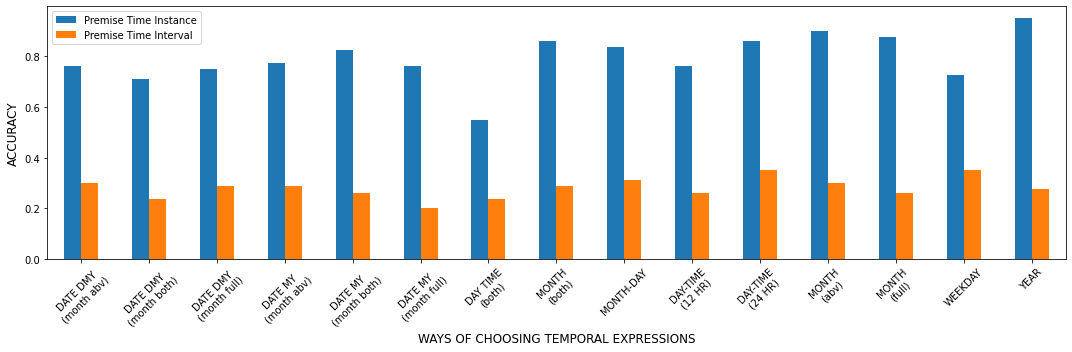

In [ ]:
ax = prem_fixed_results_df.plot.bar(figsize=(15,5))
ax.set_xticklabels(labels=prem_fixed_results_df.index, rotation=45)
plot = ax.get_figure()
plt.xlabel('WAYS OF CHOOSING TEMPORAL EXPRESSIONS', fontsize=12)
plt.ylabel('ACCURACY', fontsize=12)
plot.tight_layout()
plot.savefig('CS_1_prem_fixed.png', format='png', dpi=1200)

##### b) UDS Ordering

In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet1DF_test_preds.csv', index_col=0)
challengeSet['label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSet['label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSet['label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet

,premise,hypothesis,label,Type,Prem Fixed,Temp Type,pred_mnli_untrained,pred_udst_untrained
0,I graduated at 11 AM.,I graduated after 12 AM.,1,SINGLE_day_time_12,True,Forward,2,1
1,The tournament was held at 8 AM.,The tournament was held before 5 PM.,1,SINGLE_day_time_12,True,Forward,2,1
2,Robin will visit her parents at 2 PM.,Robin will visit her parents before 6 AM.,0,SINGLE_day_time_12,True,Forward,0,1
3,They are planning to go to Singapore at 4 PM.,They are planning to go to Singapore before 6 AM.,0,SINGLE_day_time_12,True,Forward,2,1
4,I submitted my PhD dissertation at 9 PM.,I submitted my PhD dissertation after 10 PM.,0,SINGLE_day_time_12,True,Forward,0,1
...,...,...,...,...,...,...,...,...
2395,"Before August 1907, they are planning to go to...","Before Sep 1966, they are planning to go to Si...",1,DATE_MY_both,False,Backward,0,1
2396,"After Jan 1954, I submitted my PhD dissertation.","Before October 1980, I submitted my PhD disser...",0,DATE_MY_both,False,Backward,0,1
2397,"Before November 1995, he was sworn in as the P...","After Oct 1998, he was sworn in as the Prime M...",0,DATE_MY_both,False,Backward,0,1
2398,"Before Sep 1942, the startup received funding.","After May 1996, the startup received funding.",0,DATE_MY_both,False,Backward,0,0


In [ ]:
challengeSet['label'].value_counts()

0    1545
1     855
Name: label, dtype: int64

In [ ]:
challengeSet['pred_udst_untrained'].value_counts()

0    1263
1    1137
Name: pred_udst_untrained, dtype: int64

In [ ]:
# Temp Type has very little effect?
challengeSet[challengeSet['pred_udst_untrained'] == challengeSet['label']]['Temp Type'].value_counts() / challengeSet['Temp Type'].value_counts()

Backward    0.588333
Forward     0.535000
Name: Temp Type, dtype: float64

In [ ]:
# Prem Fixed has no major effect
challengeSet[challengeSet['pred_udst_untrained'] == challengeSet['label']]['Prem Fixed'].value_counts() / challengeSet['Prem Fixed'].value_counts()

False    0.565833
True     0.557500
Name: Prem Fixed, dtype: float64

In [ ]:
# Distribution of accuracy for Prem Fixed == True
challengeSet[(challengeSet['pred_udst_untrained'] == challengeSet['label']) & (challengeSet['Prem Fixed'] == True)]['Type'].value_counts() / challengeSet[challengeSet['Prem Fixed'] == True]['Type'].value_counts()

DATE_DMY_abv          0.5125
DATE_DMY_both         0.4875
DATE_DMY_full         0.5250
DATE_MY_abv           0.5875
DATE_MY_both          0.6000
DATE_MY_full          0.5875
MULTI_day_time        0.5000
MULTI_month           0.5250
SINGLE_date           0.6125
SINGLE_day_time_12    0.5500
SINGLE_day_time_24    0.5500
SINGLE_month_abv      0.5750
SINGLE_month_full     0.5500
SINGLE_weekday        0.5625
SINGLE_year           0.6375
Name: Type, dtype: float64

In [ ]:
# Distribution of accuracy for Prem Fixed == False
challengeSet[(challengeSet['pred_udst_untrained'] == challengeSet['label']) & (challengeSet['Prem Fixed'] == False)]['Type'].value_counts() / challengeSet[challengeSet['Prem Fixed'] == False]['Type'].value_counts()

DATE_DMY_abv          0.4625
DATE_DMY_both         0.5375
DATE_DMY_full         0.4500
DATE_MY_abv           0.6000
DATE_MY_both          0.5375
DATE_MY_full          0.4625
MULTI_day_time        0.6500
MULTI_month           0.5250
SINGLE_date           0.6625
SINGLE_day_time_12    0.5625
SINGLE_day_time_24    0.8375
SINGLE_month_abv      0.5375
SINGLE_month_full     0.5000
SINGLE_weekday        0.6000
SINGLE_year           0.5625
Name: Type, dtype: float64

In [ ]:
# Type with max acc for Prem Fixed == False is somewhat skewed
challengeSet[(challengeSet['Type'] == 'SINGLE_day_time_24') & (challengeSet['Prem Fixed'] == False)]['label'].value_counts()

0    68
1    12
Name: label, dtype: int64

### 1. Challenge Set 2

##### a) MultiNLI

In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test_preds.csv', index_col=0)
challengeSet['label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSet['label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSet['label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet

,premise,hypothesis,label,Type,Dur Type,Next Cycle,Temp Type,pred_mnli_untrained,pred_udsd_untrained
0,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,2,SINGLE_day_time_12,EQUAL_GOLD,True,Spread,1,1
1,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread,1,1
2,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread,1,1
3,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread,1,1
4,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,MORE_GOLD,True,Spread,2,1
...,...,...,...,...,...,...,...,...,...
19,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for more than 59...,2,DATE_YM_both,MORE_GOLD-1,False,Near,2,0
20,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,0,DATE_YM_both,LESS_GOLD,False,Near,2,1
21,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 60...,2,DATE_YM_both,LESS_GOLD+1,False,Near,2,1
22,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,2,DATE_YM_both,LESS_GOLD*10,False,Near,2,0


In [ ]:
challengeSet['label'].value_counts()

0    3468
2    1734
Name: label, dtype: int64

In [ ]:
# Predictions are skewed
challengeSet['pred_mnli_untrained'].value_counts()

2    4568
0     350
1     284
Name: pred_mnli_untrained, dtype: int64

In [ ]:
challengeSet['pred_mnli_untrained'].value_counts() / sum(challengeSet['pred_mnli_untrained'].value_counts())

2    0.878124
0    0.067282
1    0.054594
Name: pred_mnli_untrained, dtype: float64

In [ ]:
# Temp Type doesn't have much effect
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Temp Type'].value_counts() / challengeSet['Temp Type'].value_counts()

Near      0.424626
Spread    0.325626
Name: Temp Type, dtype: float64

In [ ]:
# Next Cycle doesn't have major effect
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Next Cycle'].value_counts() / challengeSet['Next Cycle'].value_counts()

False    0.364796
True     0.397252
Name: Next Cycle, dtype: float64

In [ ]:
# Type doesn't have major effect
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Type'].value_counts() / challengeSet['Type'].value_counts()

DATE_M_abv            0.304167
DATE_M_both           0.300000
DATE_M_full           0.304167
DATE_YM_abv           0.341667
DATE_YM_both          0.354167
DATE_YM_full          0.350000
MULTI_day_time        0.371308
MULTI_month           0.408602
SINGLE_date           0.385281
SINGLE_day_time_12    0.387841
SINGLE_day_time_24    0.382166
SINGLE_month_abv      0.396624
SINGLE_month_full     0.418259
SINGLE_weekday        0.422078
SINGLE_year           0.350211
Name: Type, dtype: float64

In [ ]:
# Most predictions are entailment, best dur type with contradiction label seem to be EQUAL_GOLD*10 and MORE_GOLD*10
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Dur Type'].value_counts() / challengeSet['Dur Type'].value_counts()

EQUAL_GOLD       0.847727
EQUAL_GOLD*10    0.361364
EQUAL_GOLD+1     0.061364
EQUAL_GOLD-1     0.084541
LESS_GOLD        0.009091
LESS_GOLD*10     0.993182
LESS_GOLD+1      1.000000
LESS_GOLD-1      0.021739
MORE_GOLD        0.002273
MORE_GOLD*10     0.163636
MORE_GOLD+1           NaN
MORE_GOLD-1      0.954106
Name: Dur Type, dtype: float64

In [ ]:
for ind, df in challengeSet.groupby('Dur Type'):
  print(ind, 'Recall:', f1_score(df['label'], df['pred_mnli_untrained'], average='weighted'))

EQUAL_GOLD Recall: 0.917589175891759
EQUAL_GOLD*10 Recall: 0.5308848080133557
EQUAL_GOLD+1 Recall: 0.11563169164882228
EQUAL_GOLD-1 Recall: 0.155902004454343
LESS_GOLD Recall: 0.018018018018018018
LESS_GOLD*10 Recall: 0.9965792474344356
LESS_GOLD+1 Recall: 1.0
LESS_GOLD-1 Recall: 0.0425531914893617
MORE_GOLD Recall: 0.0045351473922902496
MORE_GOLD*10 Recall: 0.28125
MORE_GOLD+1 Recall: 0.0
MORE_GOLD-1 Recall: 0.9765142150803461


In [ ]:
# EQUAL_GOLD*10 and MORE_GOLD*10 form 259/350 contradiction labels
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Dur Type'].value_counts()

LESS_GOLD+1      440
LESS_GOLD*10     437
MORE_GOLD-1      395
EQUAL_GOLD       373
EQUAL_GOLD*10    159
MORE_GOLD*10      72
EQUAL_GOLD-1      35
EQUAL_GOLD+1      27
LESS_GOLD-1        9
LESS_GOLD          4
MORE_GOLD          1
Name: Dur Type, dtype: int64

##### b) UDS Duration

In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test_preds.csv', index_col=0)
challengeSet['label'].replace(to_replace='Entailment', value=1, inplace=True)
challengeSet['label'].replace(to_replace='Neutral', value=0, inplace=True)
challengeSet['label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet

,premise,hypothesis,label,Type,Dur Type,Next Cycle,Temp Type,pred_mnli_untrained,pred_udsd_untrained
0,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,1,SINGLE_day_time_12,EQUAL_GOLD,True,Spread,1,1
1,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread,1,1
2,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread,1,1
3,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread,1,1
4,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,MORE_GOLD,True,Spread,2,1
...,...,...,...,...,...,...,...,...,...
19,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for more than 59...,1,DATE_YM_both,MORE_GOLD-1,False,Near,2,0
20,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,0,DATE_YM_both,LESS_GOLD,False,Near,2,1
21,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 60...,1,DATE_YM_both,LESS_GOLD+1,False,Near,2,1
22,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,1,DATE_YM_both,LESS_GOLD*10,False,Near,2,0


In [ ]:
challengeSet['label'].value_counts()

0    3468
1    1734
Name: label, dtype: int64

In [ ]:
# Predictions are skewed
challengeSet['pred_udsd_untrained'].value_counts()

0    3616
1    1586
Name: pred_udsd_untrained, dtype: int64

In [ ]:
# Temp Type doesn't have much effect
challengeSet[challengeSet['pred_udsd_untrained'] == challengeSet['label']]['Temp Type'].value_counts() / challengeSet['Temp Type'].value_counts()

Near      0.609896
Spread    0.638150
Name: Temp Type, dtype: float64

In [ ]:
# Next Cycle doesn't have major effect
challengeSet[challengeSet['pred_udsd_untrained'] == challengeSet['label']]['Next Cycle'].value_counts() / challengeSet['Next Cycle'].value_counts()

False    0.632086
True     0.606930
Name: Next Cycle, dtype: float64

In [ ]:
# Type effect similar as challenge set 1
challengeSet[challengeSet['pred_udsd_untrained'] == challengeSet['label']]['Type'].value_counts() / challengeSet['Type'].value_counts()

DATE_M_abv            0.575000
DATE_M_both           0.583333
DATE_M_full           0.608333
DATE_YM_abv           0.666667
DATE_YM_both          0.654167
DATE_YM_full          0.662500
MULTI_day_time        0.529536
MULTI_month           0.662366
SINGLE_date           0.683983
SINGLE_day_time_12    0.540881
SINGLE_day_time_24    0.543524
SINGLE_month_abv      0.660338
SINGLE_month_full     0.685775
SINGLE_weekday        0.694805
SINGLE_year           0.666667
Name: Type, dtype: float64

In [ ]:
challengeSet[challengeSet['pred_udsd_untrained'] == challengeSet['label']]['Dur Type'].value_counts() / challengeSet['Dur Type'].value_counts()

EQUAL_GOLD       0.195455
EQUAL_GOLD*10    0.818182
EQUAL_GOLD+1     0.813636
EQUAL_GOLD-1     0.789855
LESS_GOLD        0.520455
LESS_GOLD*10     0.638636
LESS_GOLD+1      0.525000
LESS_GOLD-1      0.521739
MORE_GOLD        0.802273
MORE_GOLD*10     0.820455
MORE_GOLD+1      0.818182
MORE_GOLD-1      0.202899
Name: Dur Type, dtype: float64

##### c) MultiNLI Trained

In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF_test_preds (1).csv', index_col=0)
challengeSet.rename(columns={'Label':'label'}, inplace=True)
challengeSet['label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSet['label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSet['label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet

,Premise,Hypothesis,label,Type,Dur Type,Next Cycle,Temp Type,pred_mnli_trained
0,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,2,SINGLE_day_time_12,EQUAL_GOLD,True,Spread,0
1,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD+1,True,Spread,0
2,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD*10,True,Spread,0
3,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,EQUAL_GOLD-1,True,Spread,0
4,The train from Seattle started at 3 PM and rea...,The train journey from Seattle to Portland las...,0,SINGLE_day_time_12,MORE_GOLD,True,Spread,0
...,...,...,...,...,...,...,...,...
19,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for more than 59...,2,DATE_YM_both,MORE_GOLD-1,False,Near,0
20,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,0,DATE_YM_both,LESS_GOLD,False,Near,0
21,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 60...,2,DATE_YM_both,LESS_GOLD+1,False,Near,0
22,I pursued my bachelors degree from Jan 1931 to...,I pursued my bachelors degree for less than 59...,2,DATE_YM_both,LESS_GOLD*10,False,Near,2


In [ ]:
challengeSet['label'].value_counts()

0    3468
2    1734
Name: label, dtype: int64

In [ ]:
# Predictions are skewed
challengeSet['pred_mnli_trained'].value_counts()

0    4740
2     462
Name: pred_mnli_trained, dtype: int64

In [ ]:
challengeSet['pred_mnli_trained'].value_counts() / sum(challengeSet['pred_mnli_trained'].value_counts())

0    0.911188
2    0.088812
Name: pred_mnli_trained, dtype: float64

In [ ]:
# Temp Type doesn't have much effect
challengeSet[challengeSet['pred_mnli_trained'] == challengeSet['label']]['Temp Type'].value_counts() / challengeSet['Temp Type'].value_counts()

Near      0.747986
Spread    0.748362
Name: Temp Type, dtype: float64

In [ ]:
# Next Cycle doesn't have major effect
challengeSet[challengeSet['pred_mnli_trained'] == challengeSet['label']]['Next Cycle'].value_counts() / challengeSet['Next Cycle'].value_counts()

False    0.744615
True     0.755675
Name: Next Cycle, dtype: float64

In [ ]:
# Type doesn't have major effect
challengeSet[challengeSet['pred_mnli_trained'] == challengeSet['label']]['Type'].value_counts() / challengeSet['Type'].value_counts()

DATE_M_abv            0.745833
DATE_M_both           0.737500
DATE_M_full           0.754167
DATE_YM_abv           0.741667
DATE_YM_both          0.745833
DATE_YM_full          0.750000
MULTI_day_time        0.744726
MULTI_month           0.746237
SINGLE_date           0.744589
SINGLE_day_time_12    0.744235
SINGLE_day_time_24    0.743100
SINGLE_month_abv      0.753165
SINGLE_month_full     0.753715
SINGLE_weekday        0.761905
SINGLE_year           0.746835
Name: Type, dtype: float64

In [ ]:
# Most predictions are entailment, best dur type with contradiction label seem to be EQUAL_GOLD*10 and MORE_GOLD*10
challengeSet[challengeSet['pred_mnli_trained'] == challengeSet['label']]['Dur Type'].value_counts() / challengeSet['Dur Type'].value_counts()

EQUAL_GOLD            NaN
EQUAL_GOLD*10    1.000000
EQUAL_GOLD+1     1.000000
EQUAL_GOLD-1     1.000000
LESS_GOLD        0.977273
LESS_GOLD*10     0.940909
LESS_GOLD+1      0.065909
LESS_GOLD-1      0.978261
MORE_GOLD        1.000000
MORE_GOLD*10     1.000000
MORE_GOLD+1      1.000000
MORE_GOLD-1           NaN
Name: Dur Type, dtype: float64

In [ ]:
for ind, df in challengeSet.groupby('Dur Type'):
  print(ind, 'Recall:', f1_score(df['label'], df['pred_mnli_trained'], average='weighted'))

EQUAL_GOLD Recall: 0.0
EQUAL_GOLD*10 Recall: 1.0
EQUAL_GOLD+1 Recall: 1.0
EQUAL_GOLD-1 Recall: 1.0
LESS_GOLD Recall: 0.9885057471264368
LESS_GOLD*10 Recall: 0.9695550351288056
LESS_GOLD+1 Recall: 0.12366737739872068
LESS_GOLD-1 Recall: 0.989010989010989
MORE_GOLD Recall: 1.0
MORE_GOLD*10 Recall: 1.0
MORE_GOLD+1 Recall: 1.0
MORE_GOLD-1 Recall: 0.0


In [ ]:
# EQUAL_GOLD*10 and MORE_GOLD*10 form 259/350 contradiction labels
challengeSet[challengeSet['pred_mnli_untrained'] == challengeSet['label']]['Dur Type'].value_counts()

LESS_GOLD+1      440
LESS_GOLD*10     437
MORE_GOLD-1      395
EQUAL_GOLD       373
EQUAL_GOLD*10    159
MORE_GOLD*10      72
EQUAL_GOLD-1      35
EQUAL_GOLD+1      27
LESS_GOLD-1        9
LESS_GOLD          4
MORE_GOLD          1
Name: Dur Type, dtype: int64

## TESTING MODELS

In [ ]:
!pip install transformers sentencepiece datasets

     |████████████████████████████████| 2.3MB 33.7MB/s 
     |████████████████████████████████| 1.2MB 43.3MB/s 
     |████████████████████████████████| 225kB 37.7MB/s 
     |████████████████████████████████| 3.3MB 47.3MB/s 
     |████████████████████████████████| 901kB 48.3MB/s 
     |████████████████████████████████| 245kB 52.4MB/s 
     |████████████████████████████████| 112kB 58.5MB/s 


In [ ]:
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from datasets import load_dataset

In [ ]:
class DataProcessor:

  def __init__(self, dataset, test_df):
    self.dataset = dataset
    self.test_df = test_df

  def read_data(self):
    premises = self.dataset['premise']
    hypotheses = self.dataset['hypothesis']
    labels = self.dataset['label']
    if self.test_df:
      return (premises.tolist(), hypotheses.tolist(), labels.tolist())
    else:
      return (premises, hypotheses, labels)


class PretrainedModel:

	def __init__(self, model_name='roberta-large-mnli', max_len=64):
		# To allow for GPU computation
		self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
		self.tokenizer = AutoTokenizer.from_pretrained(model_name)
		self.model = AutoModelForSequenceClassification.from_pretrained(model_name).to(self.device)
		self.max_len = max_len

	# Return IDs as tensors
	def get_token_ids(self, premises, hypotheses):
		num_premises = len(premises)
		num_hypotheses = len(hypotheses)
		assert (num_premises == num_hypotheses)
		ids = []
		masks = []
		types = []
		for i in range(num_premises):
			# Tokenizer will combine the premise and hypothesis with special tokens
			# Note - Roberta's/some others' tokenizers will use <s> & </s> instead
			# of [CLS] and [SEP]
			t_e = self.tokenizer.encode_plus(premises[i], hypotheses[i],
											 max_length=self.max_len,
											 add_special_tokens=True,
											 padding='max_length',
                       truncation=True,
											 return_tensors="pt",
											 return_token_type_ids=True,
											 return_attention_mask=True)
			ids.append(t_e['input_ids'])
			masks.append(t_e['attention_mask'])

			# Note - Roberta does not need or output proper token_type_ids, but others
			# (like BERT) will. Still keep them for now, I think it won't affect model's output
			types.append(t_e['token_type_ids'])
		ids = torch.cat(tuple(ids))
		masks = torch.cat(tuple(masks))
		types = torch.cat(tuple(types))
		return (ids, masks, types)

	def predict(self, test_dataset, test_df=True, pretrained=None, bs=32):
		# Get premises, hypotheses, labels
		test_p, test_h, test_l = DataProcessor(test_dataset, test_df).read_data()

		# Calls the tokenizer, then uses a DataLoader to read batches of the tensor-ized data
		ids, masks, types = self.get_token_ids(test_p, test_h)
		dataloader = DataLoader(TensorDataset(ids, masks, types), batch_size=bs)
		
		self.model.eval()

		pred = []
		for step, batch in enumerate(dataloader):
			# Should allow for GPU computation
			batch_ids, batch_mask, batch_types = tuple((t.to(self.device) for t in batch))
			with torch.no_grad():
				# Don't need token_type_ids for Roberta, but shouldn't matter since they're all 0?
				outputs = self.model(input_ids=batch_ids, token_type_ids=batch_types, attention_mask=batch_mask)
			logits = outputs[0]
			logits = logits.detach().cpu()
			probs = softmax(logits, dim=0)  # Could use to make sure dim=0 is correct
			preds = np.argmax(probs, axis=1)  # Could use to make sure axis=1 is correct
			pred.extend(preds.tolist())

		acc = float(sum([pred[i] == test_l[i] for i in range(len(test_l))])) / float(len(test_l))
		return pred, test_l, acc

In [ ]:
def replaceLabels(row):
  if row['label'] == 0:
    row['label'] = 2
  elif row['label'] == 2:
    row['label'] = 0
  return row

dataset = load_dataset('multi_nli', split='validation_matched')
dataset = dataset.map(replaceLabels)


Using custom data configuration default


Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/default/0.0.0/591f72eb6263d1ab527561777936b199b714cda156d35716881158a2bd144f39. Subsequent calls will reuse this data.


In [ ]:
challengeSet = pd.read_csv('/content/drive/MyDrive/Projects/Temporal Awareness/challengeSet2DF.csv', index_col=0)
challengeSet['Label'].replace(to_replace='Entailment', value=2, inplace=True)
challengeSet['Label'].replace(to_replace='Neutral', value=1, inplace=True)
challengeSet['Label'].replace(to_replace='Contradiction', value=0, inplace=True)
challengeSet.rename(columns={'Premise':'premise', 'Hypothesis':'hypothesis', 'Label':'label'}, inplace=True)
challengeSet

,premise,hypothesis,label,Type,Next Cycle,Temp Type
0,Michael reached my house at 8 PM and left at 3...,Michael visited my house for 19 hours.,2,SINGLE_day_time_12,True,Spread
1,Michael reached my house at 8 PM and left at 3...,Michael visited my house for 20 hours.,0,SINGLE_day_time_12,True,Spread
2,Michael reached my house at 8 PM and left at 3...,Michael visited my house for 190 hours.,0,SINGLE_day_time_12,True,Spread
3,Michael reached my house at 8 PM and left at 3...,Michael visited my house for 18 hours.,0,SINGLE_day_time_12,True,Spread
4,Michael reached my house at 8 PM and left at 3...,Michael visited my house for more than 19 hours.,0,SINGLE_day_time_12,True,Spread
...,...,...,...,...,...,...
31,The country was under a dictatorship from Sept...,The country was under a dictatorship for more ...,2,DATE_year_months,False,Near
32,The country was under a dictatorship from Sept...,The country was under a dictatorship for less ...,0,DATE_year_months,False,Near
33,The country was under a dictatorship from Sept...,The country was under a dictatorship for less ...,2,DATE_year_months,False,Near
34,The country was under a dictatorship from Sept...,The country was under a dictatorship for less ...,2,DATE_year_months,False,Near


In [ ]:
MODEL_NAME = 'roberta-large-mnli'
BATCH_SIZE = 32
MAX_LEN = 64

model = PretrainedModel(model_name=MODEL_NAME, max_len=MAX_LEN)

preds, labels, acc = model.predict(test_dataset=dataset, test_df=False, bs=BATCH_SIZE)
print('MNLI ACC : ', acc)

preds, labels, acc = model.predict(test_dataset=challengeSet, test_df=True, bs=BATCH_SIZE)
print('ACC : ', acc)

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


MNLI ACC :  0.8900662251655629
ACC :  0.39174674957603167
